# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [3]:
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


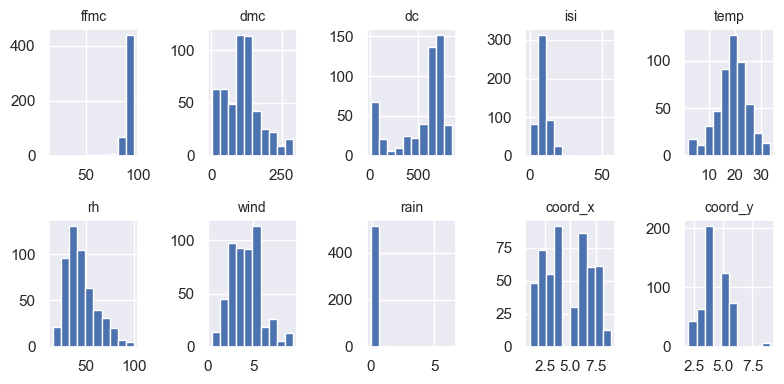

In [4]:
# NUMERIC VARIABLES
# NOTE: I treated the spatial coordinates as numeric instead of categorical because they can be transformed
# ffmc - fine fuel moisture content
# dmc - duff moisture content
# dc - drought code
# isi - initial spread index
num_cols = ['ffmc','dmc','dc','isi','temp','rh','wind','rain','coord_x','coord_y']

fig, axes = plt.subplots(2,5, figsize=(8,4))
axes = axes.flatten()

for idx, c in enumerate(num_cols):
    fires_dt[c].plot(kind='hist',ax=axes[idx],ylabel='')
    axes[idx].set_title(c, size=10)

plt.tight_layout()
plt.show()

In [5]:
fires_dt[num_cols].describe()

,ffmc,dmc,dc,isi,temp,rh,wind,rain,coord_x,coord_y
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,4.669246,4.299807
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,2.313778,1.229900
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,1.000000,2.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,3.000000,4.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,4.000000,4.000000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,7.000000,5.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,9.000000,9.000000


In [6]:
# CATEGORICAL VARIABLES
cat_cols = ['month','day']

fires_dt['day'] = pd.Categorical(fires_dt['day'],categories=['sun','mon','tue','wed','thu','fri','sat'])
fires_dt['month'] = pd.Categorical(fires_dt['month'],categories=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

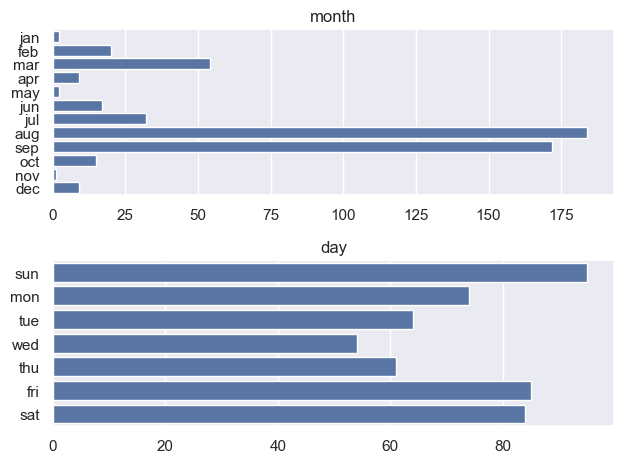

In [7]:
fig, axes = plt.subplots(2,1)
axes = axes.flatten()

for idx, c in enumerate(cat_cols):
    fires_dt[c] = fires_dt[c].sort_values()
    # fires_dt[c] = fires_dt[c].astype(int).sort_values()
    sns.countplot(y=c, data=fires_dt, ax=axes[idx])
    axes[idx].set_ylabel('')
    axes[idx].set_xlabel('')
    axes[idx].set_title(c)

plt.tight_layout()
plt.show()

In [8]:
# convert back to make it easier for training
fires_dt[cat_cols] = fires_dt[cat_cols].astype(str)
# fires_dt.dtypes

In [9]:
# BASE ESTIMATOR: RIDGE OR LASSO?
# NOTE: 3 vars (ffmc, dc, temp) are highly collinear --> choose ridge regression as the base estimator
from statsmodels.stats.outliers_influence import variance_inflation_factor

selected_dt = fires_dt.select_dtypes(include=[float])

for idx, c in enumerate(selected_dt.columns):
    print(c, variance_inflation_factor(selected_dt, idx))

ffmc 26.398928539300318
dmc 8.016102426212443
dc 12.15775011193459
isi 6.3914313973452135
temp 19.36541975460402
wind 6.646240951874564
rain 1.0195151475460693
area 1.0559036218926312


# Get X and Y

Create the features data frame and target data.

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

In [11]:
X = fires_dt.iloc[:,:-1].copy()
Y = fires_dt.iloc[:,-1].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=786)

In [12]:
# looks good!
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(361, 12) (361,) (156, 12) (156,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [13]:
preproc1 = ColumnTransformer([
    ('scaler', RobustScaler(), num_cols),
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore'), cat_cols)
])

In [14]:
preproc1

ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind', 'rain', 'coord_x', 'coord_y']),
                                ('encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['month', 'day'])])

In [15]:
pd.set_option('display.max_columns',100)

# eye test
# pd.DataFrame(preproc1.fit_transform(fires_dt))

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [16]:
# NOTE: Don't need to use remainders since all features will be transformed
# Only the transformed variables are included in the features set
preproc2 = ColumnTransformer([
    ('scaler', RobustScaler(), ['ffmc','isi','temp','rh','wind','rain','coord_x','coord_y']),
    ('encoder',OneHotEncoder(drop='first',handle_unknown='ignore'), ['day','month']),
    ('transform', QuantileTransformer(output_distribution='normal'), ['dmc', 'dc'])
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error

In [18]:
# Pipeline A = preproc1 + baseline
pipe_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])

In [19]:
# Pipeline B = preproc2 + baseline
pipe_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

In [20]:
# Pipeline C = preproc1 + advanced model
pipe_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())
])

In [21]:
# Pipeline D = preproc2 + advanced model
pipe_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [22]:
param_grid_lreg = {
    'regressor__alpha': [1e1,1e2,1e3,1e4,1e5],
}

param_grid_rf = {
    'regressor__n_estimators':[50,75,100,200,500]
}

In [23]:
dict_of_experiments = {
    'exp1':[pipe_a, param_grid_lreg],
    'exp2':[pipe_b, param_grid_lreg],
    'exp3':[pipe_c, param_grid_rf],
    'exp4':[pipe_d, param_grid_rf]
}

In [24]:
# NOTE: Aware of the current warnings – uncomment if adding
import warnings
warnings.filterwarnings("ignore")

In [25]:
for idx, p in enumerate(dict_of_experiments):
    grid_cv = GridSearchCV(
        estimator=dict_of_experiments[p][0],
        param_grid=dict_of_experiments[p][1],
        scoring='neg_root_mean_squared_error',
        cv=5,
        # error_score='raise'
    )
grid_cv.fit(X_train,Y_train)
df_results = pd.DataFrame(grid_cv.cv_results_)

# Evaluate

+ Which model has the best performance?

In [26]:
df_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.649464,0.012132,0.012921,0.000244,500,{'regressor__n_estimators': 500},-39.809654,-127.734105,-46.357531,-35.520662,-116.250555,-73.134501,40.205630,1
2,0.144013,0.013874,0.005023,0.000267,100,{'regressor__n_estimators': 100},-36.688342,-128.939137,-49.030562,-37.039201,-114.467609,-73.232970,40.086726,2
3,0.285281,0.040316,0.007072,0.000612,200,{'regressor__n_estimators': 200},-41.189391,-127.741048,-47.351458,-38.461700,-117.182878,-74.385295,39.501318,3
1,0.102448,0.001885,0.004311,0.000079,75,{'regressor__n_estimators': 75},-39.957582,-127.498580,-47.497415,-37.727665,-122.026281,-74.941505,40.843959,4
0,0.071620,0.001891,0.003753,0.000167,50,{'regressor__n_estimators': 50},-41.893673,-128.058022,-47.929192,-39.057524,-118.240476,-75.035777,39.511024,5


In [27]:
# check
print(grid_cv.best_score_, grid_cv.best_params_)

-73.1345014180441 {'regressor__n_estimators': 500}


As shown above, the Random Forest Regression model with n_estimators=100 is the best one.

# Export

+ Save the best performing model to a pickle file.

In [28]:
import pickle

In [29]:
best_model = grid_cv.best_estimator_

with open('best_model_rf.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [30]:
import shap

In [31]:
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

In [32]:
X_test_transformed.shape

(156, 26)

In [33]:
# pass
len(best_model.named_steps['preprocessing'].get_feature_names_out())

26

In [34]:
explainer = shap.explainers.TreeExplainer(
    best_model.named_steps['regressor'],
    X_test_transformed,
    feature_names = best_model.named_steps['preprocessing'].get_feature_names_out())

In [35]:
shap_values = explainer(X_test_transformed, check_additivity=False)

## For an individual prediction
We can analyze individual predictions with the help of a waterfall plot. It shows the most important features in order of importance (see below). We observe that the top 5 features for this prediction are the first 5 features reading from top to bottom. The features in red are positively correlated, while those in blue are negatively correlated with the prediction score.

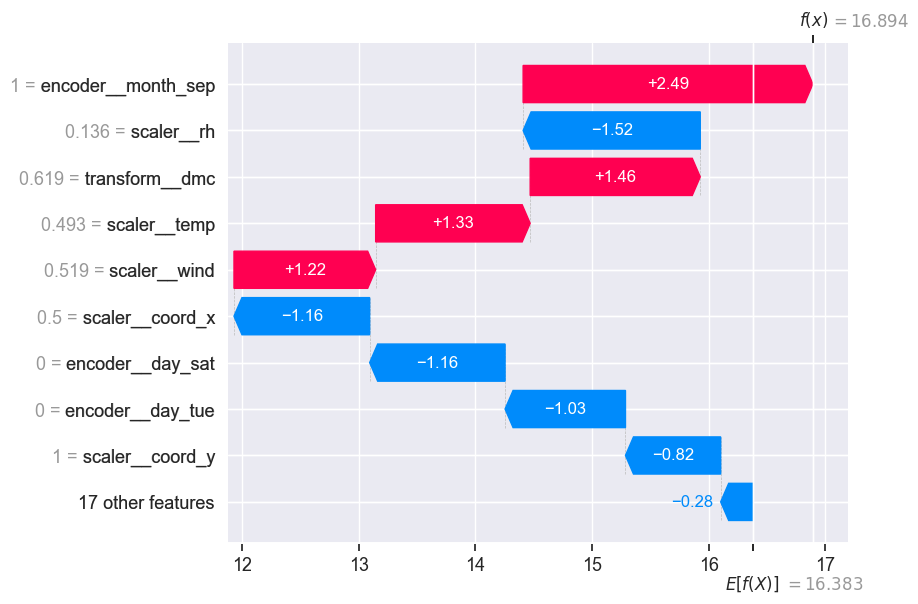

In [47]:
shap.plots.waterfall(shap_values[1])

## Across all predictions
We can analyze the most and least important features across all predictions in the test dataset using a beeswarm plot. 

We observe that the top 3 features are (more stable):
1. `scaler__temp`
2. `scaler__coord_x`
3. `transform__dmc`

The bottom 3 features are (less stable):
1. `scaler__coord_y`
2. `encoder__day_sat`
3. `encoder__month_sep`

### Improving model performance
Besides the top 6 features, the other 20 features have a negligible impact on the predictive score of the model. Hence, we should consider removing them from the model.

We can re-train the model through the pipeline to assess the improvement in RMSE from dropping these features.

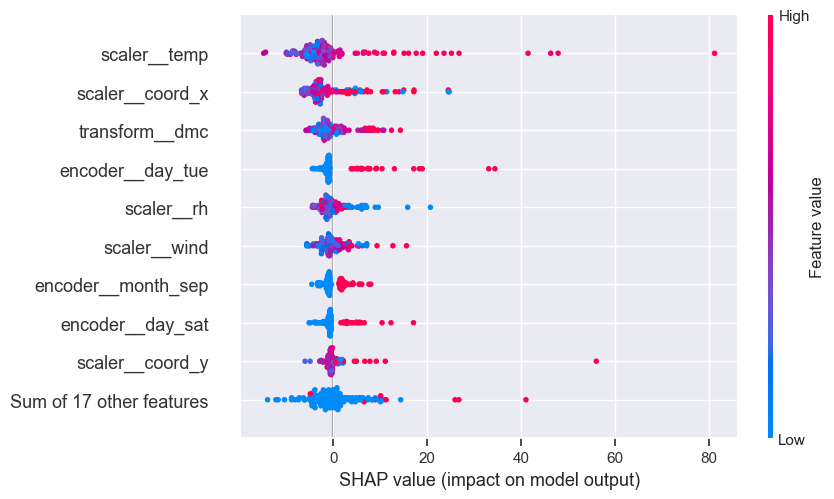

In [37]:
shap.plots.beeswarm(shap_values)

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [x] Created a branch with the correct naming convention.
- [x] Ensured that the repository is public.
- [x] Reviewed the PR description guidelines and adhered to them.
- [x] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.